# Household Power Consumption Capstone project


**Akhilesh Varigonda**

#### Library loading

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

The libaries here were used to make the analysis of the household power consumption throughout the years and make analysis as conclusions the research question. 

#### Data Preperation 

In [2]:
warnings.filterwarnings("ignore", message="The figure layout has changed to tight", module="seaborn.axisgrid")

# Loading the dataset
data = pd.read_csv('household_power_consumption.csv')

# Converting Date column to datetime type
data['Date'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], dayfirst=True)

# Ensuring numeric values in the important columns
numeric_columns = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
for col in numeric_columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Removing rows with missing values
data.dropna(inplace=True)

# Aggregating data as a daily average
daily_data = data.groupby(data['Date'].dt.date).agg({
    'Global_active_power': 'mean',
    'Global_reactive_power': 'mean',
    'Voltage': 'mean',
    'Global_intensity': 'mean',
    'Sub_metering_1': 'mean',
    'Sub_metering_2': 'mean',
    'Sub_metering_3': 'mean'
}).reset_index()

# Extracting year, month, and day and day of week features
daily_data['Year'] = pd.to_datetime(daily_data['Date']).dt.year
daily_data['Month'] = pd.to_datetime(daily_data['Date']).dt.month
daily_data['Day'] = pd.to_datetime(daily_data['Date']).dt.day
daily_data['DayOfWeek'] = pd.to_datetime(daily_data['Date']).dt.dayofweek

# Dropping the original Date column
daily_data.drop(columns=['Date'], inplace=True)


This prepares the household power consumption data. I made all the numerical variables average by daily so it shows a better representation of the flucations of the values throughout the two years. Using datetime I extracted the dates so it will display the daily values for the important variables throughtout the two year in the graph. 

#### Correlation Matrix Heatmap

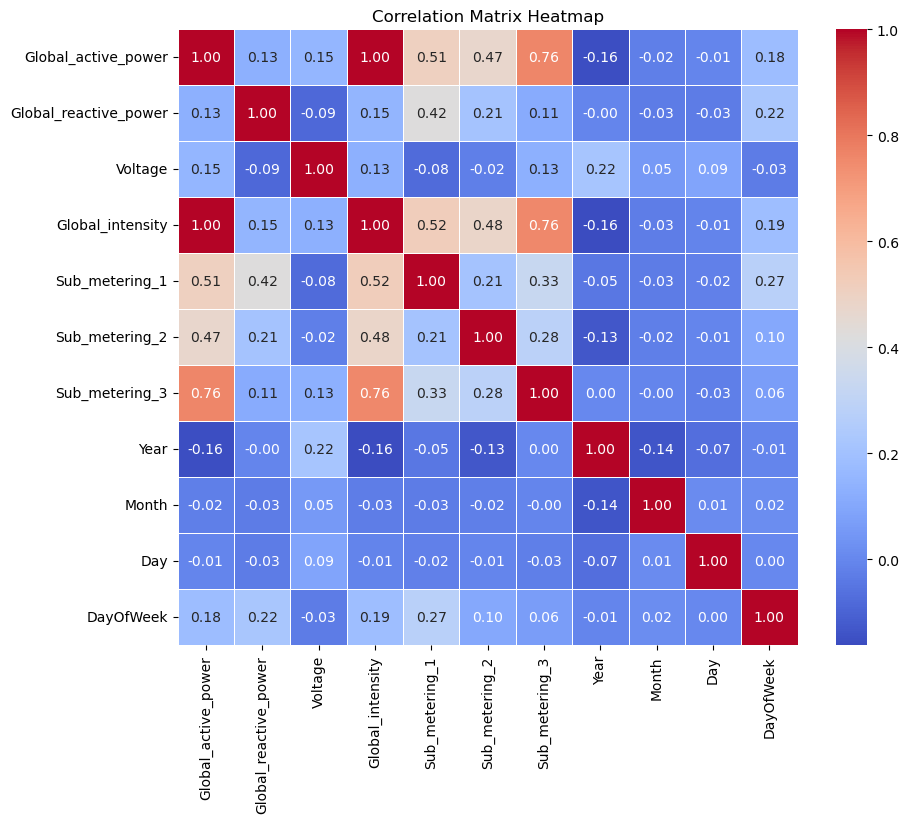

In [3]:
# Calculate the correlation matrix of all the daily average values
corr_matrix = daily_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

This is the heatmap that shows the correlation for all the combinations of the daily averages for two variables. This is nessasary because these were used as independent variables when making a prediction using random forest variables. Based on the correlation matrix global active power vs global intensity which has a really strong positive correlation of 1. global active power vs sub metering 3 also has a strong correlations as well as Global Intensity vs Sub Metering 3. That also means we will look in to the prediction using random forest regression to see the predictions of global active power, global intensity and sub metering 3. The graphs for global active power vs. global intensity, global active power vs sub metering 3, and global intensity vs sub metering 3. 

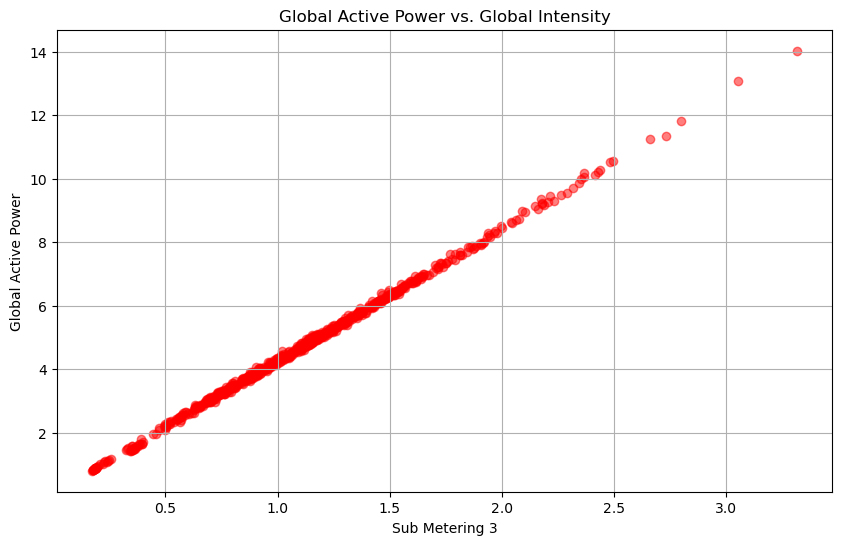

In [4]:
plt.figure(figsize=(10, 6))

# Scatter plot of Global Active Power vs. Sub Metering 3
plt.scatter(daily_data['Global_active_power'], daily_data['Global_intensity'], color='red', alpha=0.5)

plt.title('Global Active Power vs. Global Intensity')
plt.ylabel('Global Active Power')
plt.xlabel('Sub Metering 3')
plt.grid(True)
plt.show()

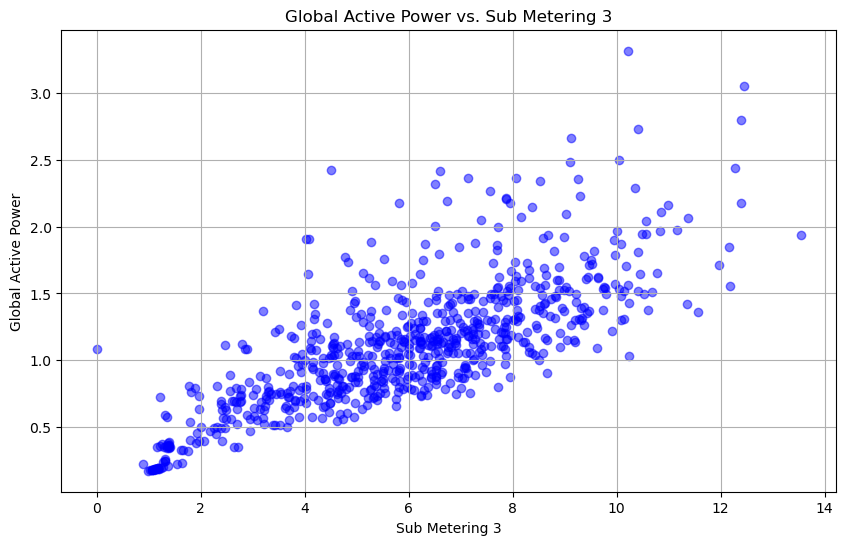

In [5]:
plt.figure(figsize=(10, 6))

# Scatter plot of Global Active Power vs. Sub Metering 3
plt.scatter(daily_data['Sub_metering_3'], daily_data['Global_active_power'], color='blue', alpha=0.5)

plt.title('Global Active Power vs. Sub Metering 3')
plt.ylabel('Global Active Power')
plt.xlabel('Sub Metering 3')
plt.grid(True)
plt.show()

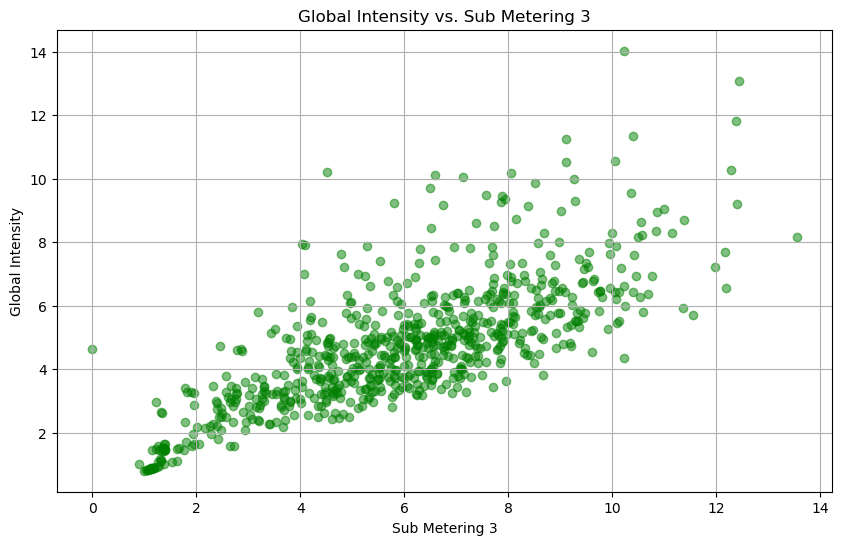

In [6]:
plt.figure(figsize=(10, 6))

# Scatter plot of Sub Metering 3 vs. Global Intensity
plt.scatter(daily_data['Sub_metering_3'], daily_data['Global_intensity'], color='green', alpha=0.5)

plt.title('Global Intensity vs. Sub Metering 3')
plt.xlabel('Sub Metering 3')
plt.ylabel('Global Intensity')
plt.grid(True)
plt.show()

## Global Active Power

In this the global active power is being used as the target with the other variables as the features in the data split of training and testing where the test size was 50%. Here the global active power is household global minute-averaged active power that the household consumes throughout the year depending on the season. But  here the global active power was averaged by date so it would show how the global active power flucuates throughout the year by season. 

#### Data Splitting for Features and Target 

In [7]:
# Splitting data into features (X) and target (y)
X = daily_data[['Year', 'Month', 'Day', 'DayOfWeek', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']]
y = daily_data['Global_active_power']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)


In this the global active power is being used as the target with the other variables as the features in the data split of training and testing where the test size was 50%. Here the global active power is household global minute-averaged active power that the household consumes throughout the year depending on the season. But here the global active power was averaged by date so it would show how the global active power flucuates throughout the year by season. 

#### Hyperparater tuning for Random Forest and Prediction Error

In [9]:
# Hyperparameter grid for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['sqrt'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Grid Search with Random Forest Regressor
rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=0)
grid_search.fit(X_train, y_train)

# Best parameters found
print("Best parameters found:")
print(grid_search.best_params_)

# Prediction Error
y_pred = grid_search.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mean_actual = y_test.mean()
rae = np.mean(np.abs(y_test - y_pred)) / np.mean(np.abs(y_test - mean_actual))
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Relative Absolute Error (RAE): {rae}")


Best parameters found:
{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Mean Squared Error (MSE): 0.018528765462330173
Root Mean Squared Error (RMSE): 0.13612040795681657
Relative Absolute Error (RAE): 0.14885495845915836


This is the output show the hyperparameter values used for the grid search shows that all the types of errors had very small errors, so the global active power predicts it well. The test size of the test split was 50%.

#### Feature Importance

Cross-Validated MSE RF: 0.017481542843611187


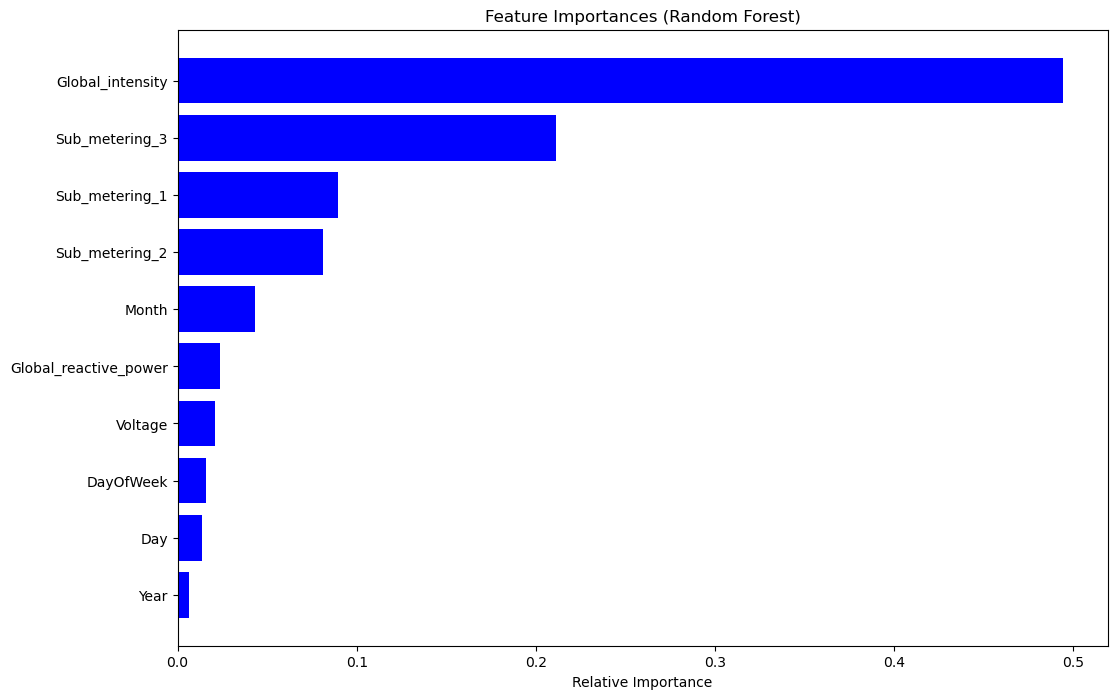

In [10]:
# Cross-Validation
scores_rf = cross_val_score(grid_search.best_estimator_, X, y, cv=3, scoring='neg_mean_squared_error')
print("Cross-Validated MSE RF:", -scores_rf.mean())

# Visualization of feature importances for Random Forest
importances = grid_search.best_estimator_.feature_importances_
features = X.columns
indices = np.argsort(importances)

plt.figure(figsize=(12, 8))
plt.title('Feature Importances (Random Forest)')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


Performs 3-fold cross-validation on the best estimator found by GridSearchCV using the features X and target y. The scoring metric used is negative mean squared error. And the mean squared error shows that the random forest regression performes well for global active power. Also notice that Global Intensity and Sub Metering 3 have the two highest relative importance which does explain why they both have a strong positive correlation. Based on the feature impornats for global active power, global intensity and sum metering 3 has the highest importance which also explains why those variables have the strongest correlation with each other. 

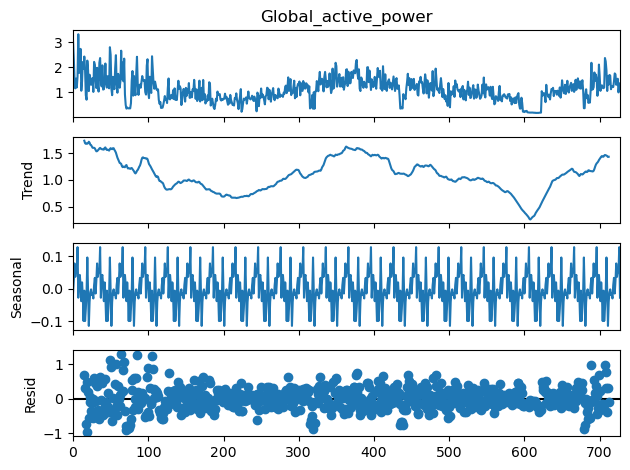

In [11]:
# Seasonal decomposition
decomposition = seasonal_decompose(daily_data['Global_active_power'], model='additive', period=30)
decomposition.plot()
plt.show()

The trend flucuations shows how the global active power changes over time in a period of two years. The season decomposition shows how seasonal global active power is as we see during a period of two year indicating that this is seasonal. And residual shows how stable it mostly look with few noises that shows how it greatly captures trend and seasonal. In here seasonal is the most important graph because it shows that the global active power changes based on season every month since here it was a period of 30 in the seasonal decomposition. 

#### Actual vs. Predicted Global Active Power graph

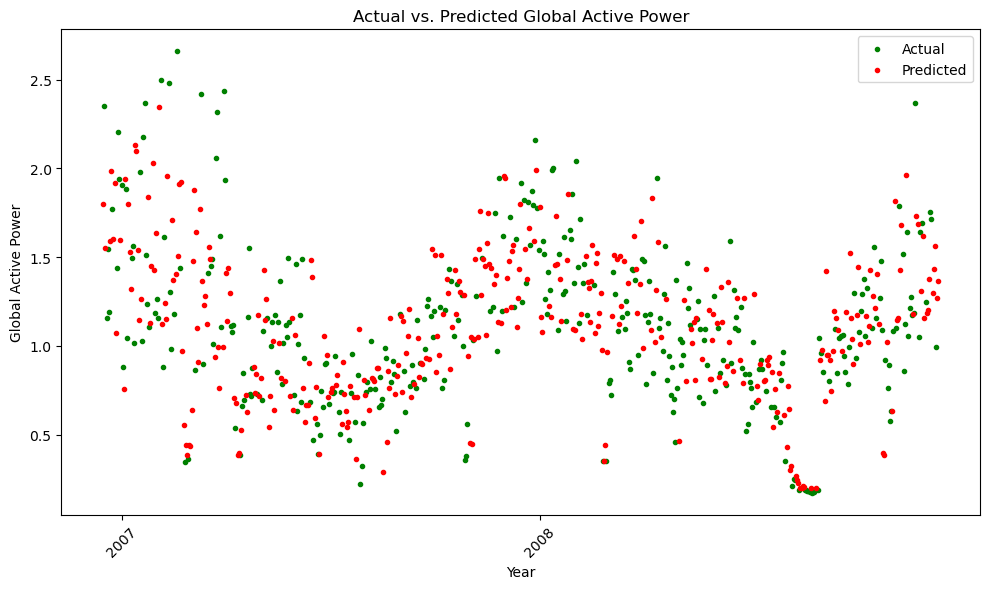

In [12]:
plt.figure(figsize=(10, 6))

plt.scatter(X_train.index, y_train, label='Actual', marker='.', color='green')

plt.scatter(X_test.index, y_pred, label='Predicted', marker='.', color='red')

# Customize x-axis labels to show only the years 2007 and 2008
tick_locations = []
tick_labels = []
for index, row in daily_data.iterrows():
    if row['Year'] == 2007 and row['Month'] == 1 and row['Day'] == 1:  
        tick_locations.append(index)
        tick_labels.append('2007')  
    elif row['Year'] == 2008 and row['Month'] == 1 and row['Day'] == 1: 
        tick_locations.append(index)
        tick_labels.append('2008')  

plt.xticks(tick_locations, tick_labels, rotation=45)

plt.title('Actual vs. Predicted Global Active Power')
plt.xlabel('Year')
plt.ylabel('Global Active Power')
plt.legend()
plt.tight_layout()
plt.show()

This graph shows the global active power with the daily average throughout the two years. It shows that actual which is the green dots and the predicted is the red dot. The difference between the actual and predicted using Random Forest Regression with multiple regression using independent values are Year, Month, Day, and the daily averages for Global_reactive_power, Voltage, Global_intensity, Sub_metering_1, Sub_metering_2, and Sub_metering_3. The dependent variable is the daily average for Global_active_power. This shows that using random forest regression does a great job in predicting without much error from the actual as the prediction error shown it above. Therefore so this can be useful for energy companies to do a better job in predicting global active power througout a year based on seasons. It does show that global active power is consumed the most during the summer and it is used less during the winter. 

#### Histograms of Actual and Predicted Global Active Power

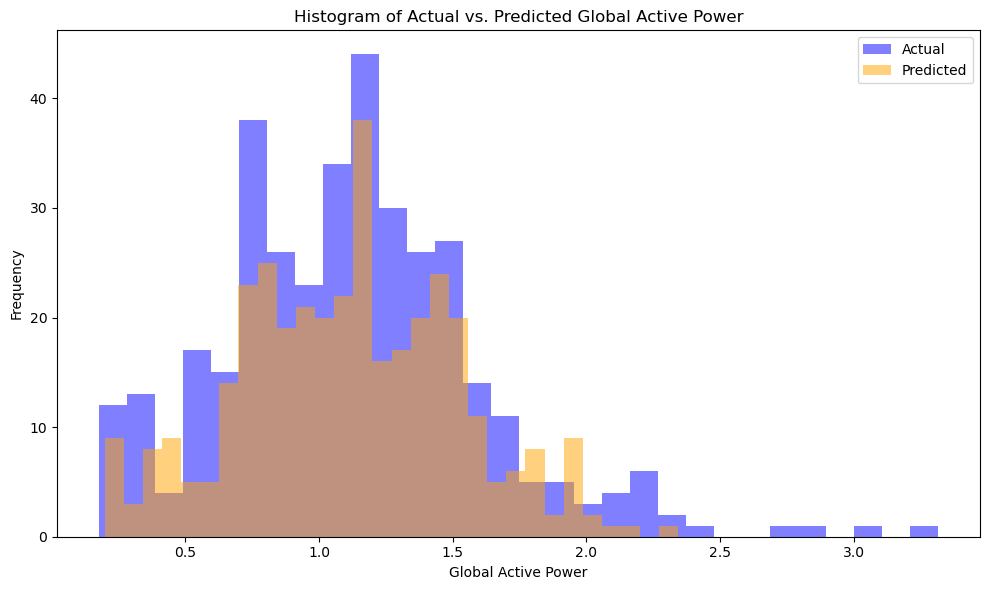

In [13]:
plt.figure(figsize=(10, 6))

plt.hist(y_test, bins=30, alpha=0.5, color='blue', label='Actual')

plt.hist(y_pred, bins=30, alpha=0.5, color='orange', label='Predicted')

plt.title('Histogram of Actual vs. Predicted Global Active Power')
plt.xlabel('Global Active Power')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

This is the histogram between the actual and predicted values for the daily average of the global active power and the frequency is higher between when the global active power is between 1.0 -1.5. The prediction does follow the frequency of the global active power however when this was around 1.0 -1.5 range there were more actual frequencies than prediction frequency, but for both prediction and actual it shows that range as the highest amount of frequency because we are testing half and training half of the entire data. 

## Global Intensity

#### Data Splitting for Features and Target 

In [14]:
# Split data into features (X_intensity) and target (y_intensity) for global intensity prediction
X_intensity = daily_data[['Year', 'Month', 'Day', 'DayOfWeek', 'Global_reactive_power', 'Voltage', 'Global_active_power', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']]
y_intensity = daily_data['Global_intensity']

# Split the data into training and testing sets
X_train_intensity, X_test_intensity, y_train_intensity, y_test_intensity = train_test_split(X_intensity, y_intensity, test_size=0.5, random_state=42)


In this the global intensity is being used as the target with the other variables as the features in the data split of training and testing where the test size was 50%. Here the global intensity is household global minute-averaged current intensity in ampere that fluctuates throughout the year depending on the season. In this the global intensity was averaged by date so it would show how the global intensity flucuates throughout the year by the season. 

#### Hyperparater tuning for Random Forest and Prediction Error

In [15]:
# Grid Search with Random Forest Regressor
grid_search_intensity = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=0)
grid_search_intensity.fit(X_train_intensity, y_train_intensity)

# Best parameters found
print("Best parameters found:")
print(grid_search_intensity.best_params_)

# Predictions and error metrics
y_pred_intensity = grid_search_intensity.predict(X_test_intensity)
mse_intensity = mean_squared_error(y_test_intensity, y_pred_intensity)
rmse_intensity = np.sqrt(mse_intensity)
mean_actual_intensity = y_test_intensity.mean()
rae_intensity = np.mean(np.abs(y_test_intensity - y_pred_intensity)) / np.mean(np.abs(y_test_intensity - mean_actual_intensity))
print(f"Mean Squared Error (MSE): {mse_intensity}")
print(f"Root Mean Squared Error (RMSE): {rmse_intensity}")
print(f"Relative Absolute Error (RAE): {rae_intensity}")


Best parameters found:
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Mean Squared Error (MSE): 0.3666804617629215
Root Mean Squared Error (RMSE): 0.6055414616381949
Relative Absolute Error (RAE): 0.1642554463021321


This is the output show the hyperparameter values used for the grid search shows that all the types of errors had very small errors, so the global intensity random forest regression predicts it well. The test size of the test split was 50%.

#### Feature Importance

Cross-Validated MSE RF: 0.3361808543116932


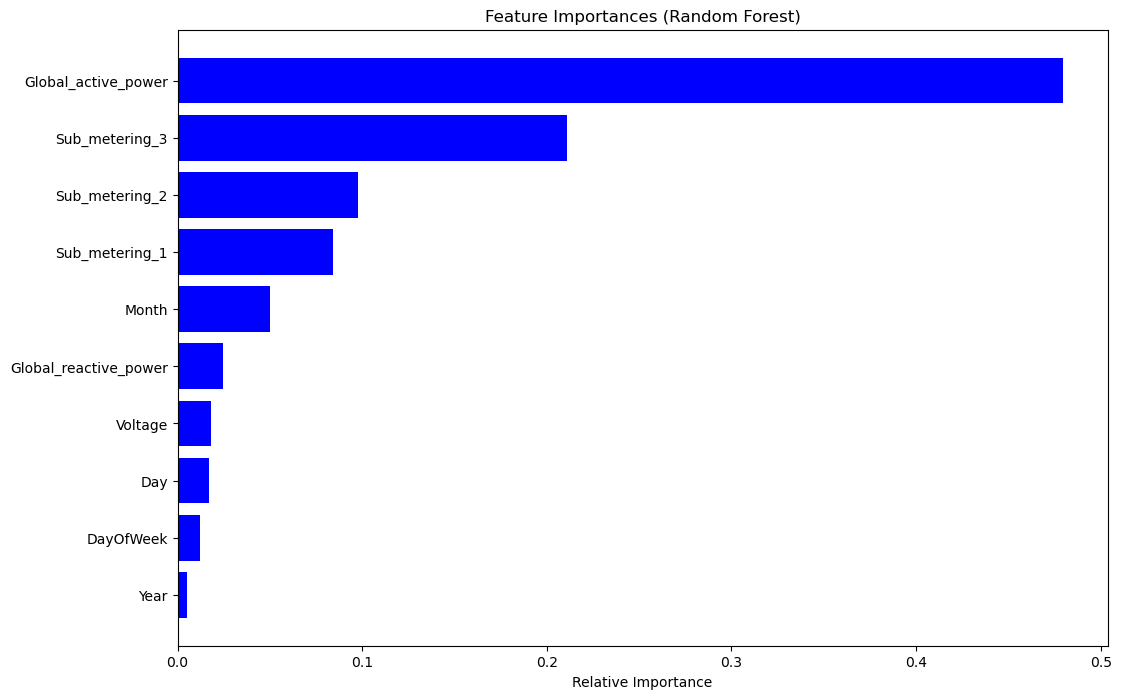

In [16]:
# Cross-Validation
scores_rf = cross_val_score(grid_search_intensity.best_estimator_, X_intensity, y_intensity, cv=5, scoring='neg_mean_squared_error')
print("Cross-Validated MSE RF:", -scores_rf.mean())

# Visualization of feature importances for Random Forest
importances = grid_search_intensity.best_estimator_.feature_importances_
features = X_intensity.columns
indices = np.argsort(importances)

plt.figure(figsize=(12, 8))
plt.title('Feature Importances (Random Forest)')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Performs 3-fold cross-validation on the best estimator found by GridSearchCV using the features X and target y. The scoring metric used is negative mean squared error. And the mean squared error shows that the random forest regression performes well for global active power. Also notice that Global Intensity and Sub Metering 3 have the two highest relative importance which does explain why they both have a strong positive correlation. Based on the feature importance for global active power and sub metering 3 has the highest importance and the correlation matrix shows those two had a high positive corralation matrix. 

#### Seasonal Decomposition

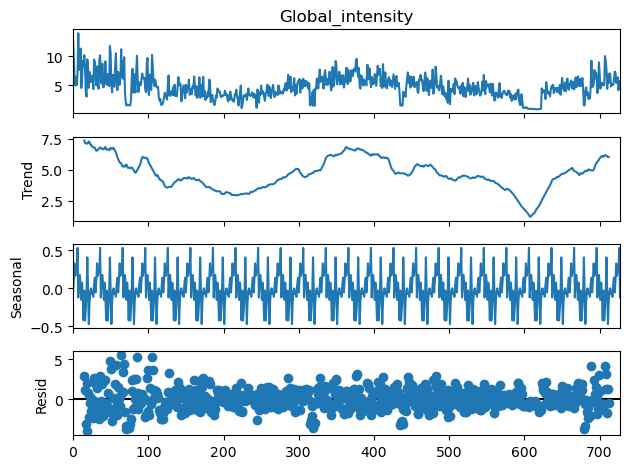

In [17]:
decomposition = seasonal_decompose(daily_data['Global_intensity'], model='additive', period=30)
decomposition.plot()
plt.show()

The trend flucuations shows how the global active power changes over time in a period of two years.

The season decomposition shows how seasonal global active power is as we see during a period of two year indicating that this is seasonal. And residual shows how stable it mostly look with few noises that shows how it greatly captures trend and seasonal. In here seasonal is the most important graph because it shows that the global active power changes based on season every month since here it was a period of 30 in the seasonal decomposition. 

#### Actual vs. Predicted Global Intensity graph

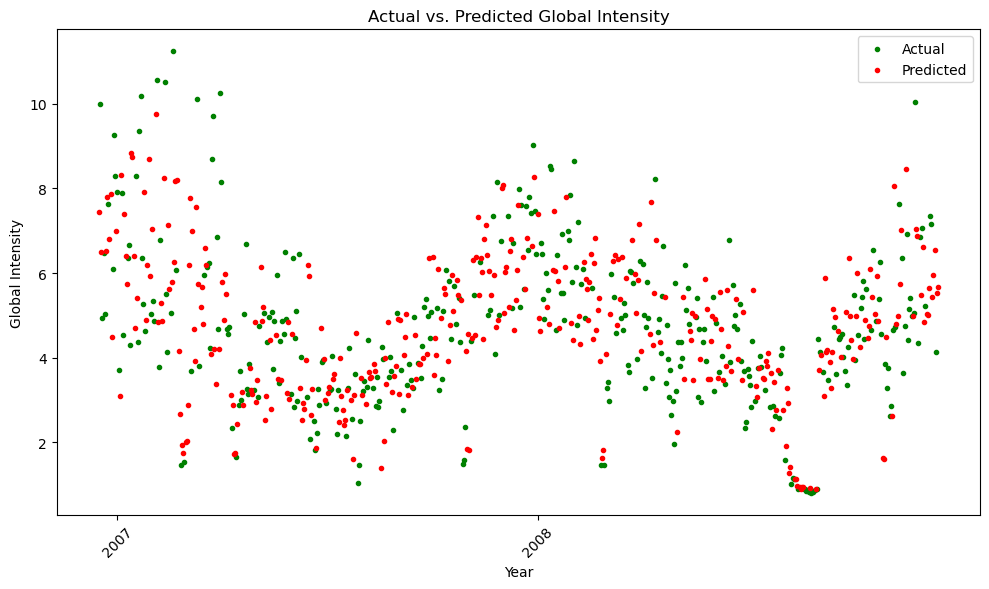

In [19]:
plt.figure(figsize=(10, 6))

plt.scatter(X_train_intensity.index, y_train_intensity, label='Actual', marker='.', color='green')

plt.scatter(X_test_intensity.index, y_pred_intensity, label='Predicted', marker='.', color='red')

# Customize x-axis labels to show only the years 2007 and 2008
tick_locations = []
tick_labels = []
for index, row in daily_data.iterrows():
    if row['Year'] == 2007 and row['Month'] == 1 and row['Day'] == 1:  
        tick_locations.append(index)
        tick_labels.append('2007')  
    elif row['Year'] == 2008 and row['Month'] == 1 and row['Day'] == 1: 
        tick_locations.append(index)
        tick_labels.append('2008')  

plt.xticks(tick_locations, tick_labels, rotation=45)

plt.title('Actual vs. Predicted Global Intensity')
plt.xlabel('Year')
plt.ylabel('Global Intensity')
plt.legend()
plt.tight_layout()
plt.show()

This graph shows the global active power with the daily average throughout the two years. It shows that actual which is the green dots and the predicted is the red dot. The difference between the actual and predicted using Random Forest Regression with multiple regression using independent values are Year, Month, Day, and the daily averages for Global_reactive_power, Voltage, Sub_metering_1, Sub_metering_2, and Sub_metering_3. The dependent variable is the daily average for Global_intensity. This shows that using random forest regression does a great job in predicting without much error from the actual, so this can be useful for energy companies to do a better job in predicting global active power througout a year based on seasons. Here the global intesity has a strong correlation with global active power energy so it is clear why more global intensity is consumed the most during the winter. 



#### Histograms of Actual and Predicted Global Intensity

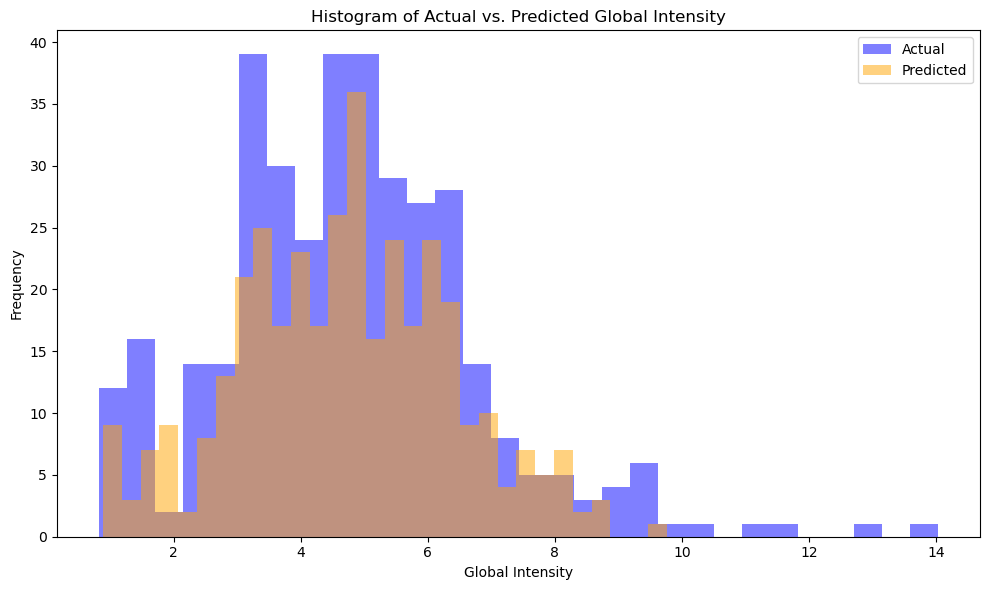

In [20]:
plt.figure(figsize=(10, 6))

plt.hist(y_test_intensity, bins=30, alpha=0.5, color='blue', label='Actual')

plt.hist(y_pred_intensity, bins=30, alpha=0.5, color='orange', label='Predicted')

plt.title('Histogram of Actual vs. Predicted Global Intensity')
plt.xlabel('Global Intensity')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

This is the histogram between the actual and predicted values for the daily average of the global intensity and the frequency is higher between when the global intensity is between 3 - 5. This is the histogram between the actual and predicted values for the daily average of the global active power and the frequency is higher between when the global intensity is between 3 - 5. The prediction does follow the frequency of the global intensity however when this was around 3 - 5 range there were more actual frequencies than prediction frequency, but for both prediction and actual it shows that range as the highest amount of frequency because we are testing half and training half of the entire data. 

## Sub Metering 3

#### Data Splitting for Features and Target 

In [21]:
# Split data into features (X_metering) and target (y_metering)
X_metering = daily_data[['Year', 'Month', 'Day', 'DayOfWeek', 'Global_reactive_power', 'Global_intensity', 'Voltage', 'Sub_metering_1', 'Sub_metering_2']]
y_metering = daily_data['Sub_metering_3']

# Split the data into training and testing sets
X_train_metering, X_test_metering, y_train_metering, y_test_metering = train_test_split(X_metering, y_metering, test_size=0.5, random_state=42)



In this the global intensity is being used as the target with the other variables as the features in the data split of training and testing where the test size was 50%. Here the sub metering 3 energy is in watt-hour of active energy. Which is for electric water-heater and an air-conditioner, and it would have a pattern based on the season since both the usage of electric water-heater and air-conditioner does impact based on the season. In here though, sub metering 3 is averaged by dates throughout the year which was be helpful to understand how sub metering 3 is consumed throughout the year. 

#### Hyperparater tuning for Random Forest and Error Prediction

In [22]:
# hyperparameter grid definition appropriate for Random Forest Regression
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['sqrt'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Random Forest Regressor for prediction
rf = RandomForestRegressor()

# Grid Search
grid_search_metering = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=0)

# Fit the grid search model
grid_search_metering.fit(X_train_metering, y_train_metering)

# Best parameters
print("Best parameters found:")
print(grid_search_metering.best_params_)

# Prediction
y_pred_metering = grid_search_metering.predict(X_test_metering)

mse_metering = mean_squared_error(y_test_metering, y_pred_metering)
print("Mean Squared Error (MSE):", mse_metering)
rmse_metering = np.sqrt(mse_metering)
print("Root Mean Squared Error (RMSE):", rmse_metering)
mean_actual_metering = y_test_metering.mean()
rae_metering = np.mean(np.abs(y_test_metering - y_pred_metering)) / np.mean(np.abs(y_test_metering - mean_actual_metering))
print("Relative Absolute Error (RAE):", rae_metering)

Best parameters found:
{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Mean Squared Error (MSE): 2.374421939122095
Root Mean Squared Error (RMSE): 1.5409159416146279
Relative Absolute Error (RAE): 0.580186613590358


This is the output show the hyperparameter values used for the grid search shows that all the types of errors had very small errors, so the sub metering 3 random forest regression predicts it well. The test size of the test split was 50%.

#### Feature Importance

Cross-Validated MSE RF: 2.603574250939885


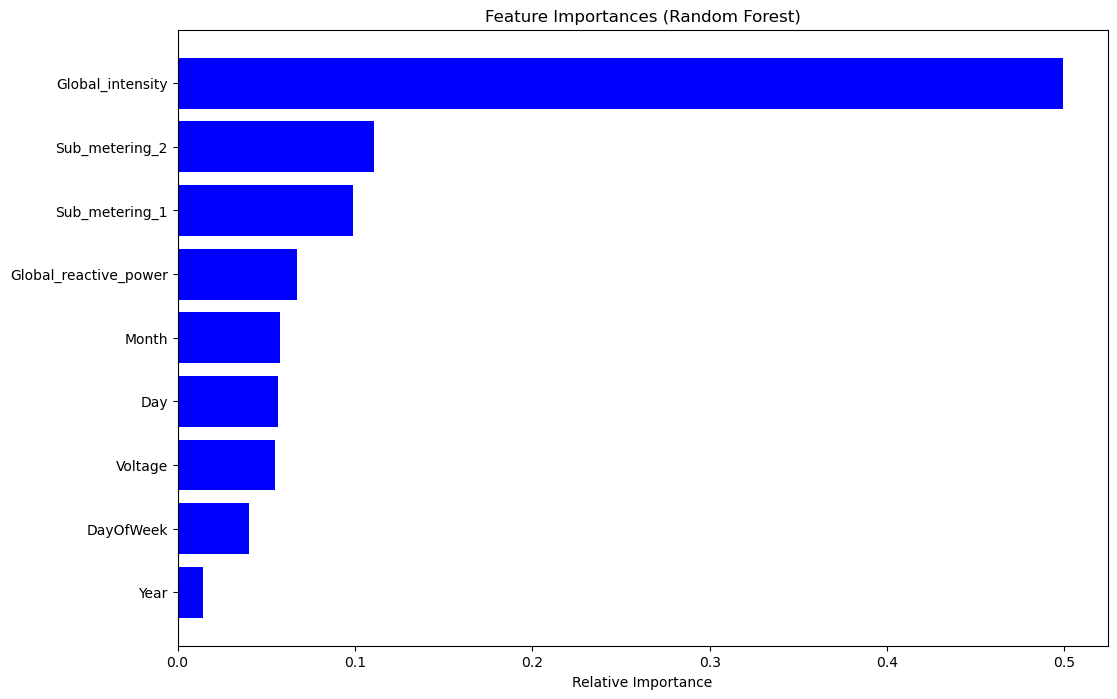

In [25]:
# Cross-Validation
scores_rf = cross_val_score(grid_search_metering.best_estimator_, X_metering, y_metering, cv=5, scoring='neg_mean_squared_error')
print("Cross-Validated MSE RF:", -scores_rf.mean())

# Visualization of feature importances for Random Forest
importances = grid_search_metering.best_estimator_.feature_importances_
features = X_metering.columns
indices = np.argsort(importances)

plt.figure(figsize=(12, 8))
plt.title('Feature Importances (Random Forest)')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Performs 3-fold cross-validation on the best estimator found by GridSearchCV using the features X and target y. The scoring metric used is negative mean squared error. And the mean squared error shows that the random forest regression performes well for global active power. Also notice that Global Intensity has the  highest relative importance which does explain why it has a strong positive correlation with sub metering 3. 

#### Seasonal Decomposition

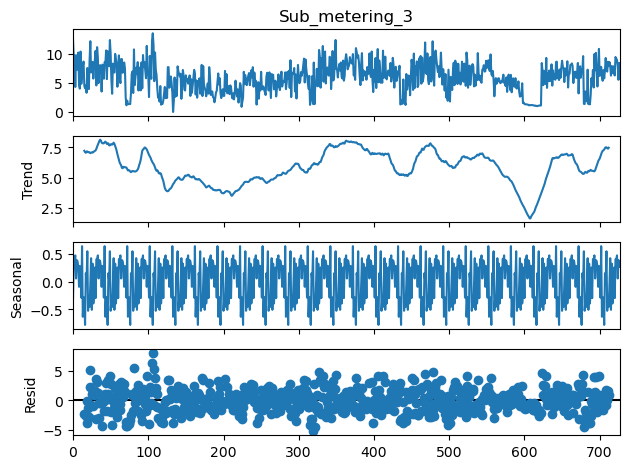

In [26]:
decomposition = seasonal_decompose(daily_data['Sub_metering_3'], model='additive', period=30)
decomposition.plot()
plt.show()

The trend flucuations shows how the global active power changes over time in a period of two years. The season decomposition shows how seasonal global active power is as we see during a period of two year indicating that this is seasonal. And residual shows how stable it mostly look with few noises that shows how it greatly captures trend and seasonal. In here seasonal is the most important graph because it shows that the global active power changes based on season every month since here it was a period of 30 in the seasonal decomposition. 

#### Actual vs. Predicted Sub Metering 3

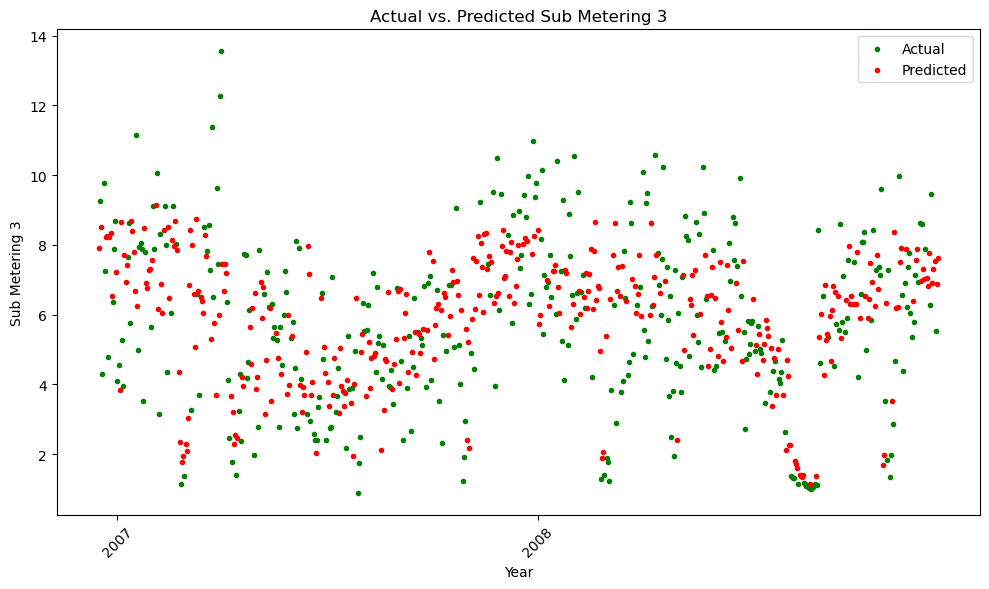

In [27]:
plt.figure(figsize=(10, 6))

plt.scatter(X_train_metering.index, y_train_metering, label='Actual', marker='.', color='green')

plt.scatter(X_test_metering.index, y_pred_metering, label='Predicted', marker='.', color='red')

# Customize x-axis labels to show only the years 2007 and 2008
tick_locations = []
tick_labels = []
for index, row in daily_data.iterrows():
    if row['Year'] == 2007 and row['Month'] == 1 and row['Day'] == 1:  
        tick_locations.append(index)
        tick_labels.append('2007')  
    elif row['Year'] == 2008 and row['Month'] == 1 and row['Day'] == 1: 
        tick_locations.append(index)
        tick_labels.append('2008')  

plt.xticks(tick_locations, tick_labels, rotation=45)

plt.title('Actual vs. Predicted Sub Metering 3')
plt.xlabel('Year')
plt.ylabel('Sub Metering 3')
plt.legend()
plt.tight_layout()
plt.show()

This graph shows the sub metering 3 with the daily average throughout the two years. It shows that actual which is the green dots and the predicted is the red dot. The difference between the actual and predicted using Random Forest Regression with multiple regression using independent values are Year, Month, Day, and the daily averages for Global_reactive_power, Voltage, Global_intensity, Sub_metering_1, and Sub_metering_2. The dependent variable is the daily average for Sub_metering_3. This shows that using random forest regression does a great job in predicting without much error from the actual, so this can be useful for energy companies to do a better job in predicting global active power througout a year based on seasons. Also in the graph it shows that heat consumer more enrgy for the air conditioner than the cooler because sub metering 3 is consumer more during the winter the most, and the least during the summer. Unlike the global power consumption and global intensity, sub metering 3 doesn't fall right away after winter is over because it does show that the cooler from the air conditioner still consumes energy but less than heater from the air conditioner. It shows that air conditioner has a bigger effect in the usage of energy than water heater, but water heater could also have a small facter based on the season. It as explains why Sub metering 3 also has a strong correlation with global active power and global intensity.  

#### Histograms of Actual and Predicted Sub Metering 3

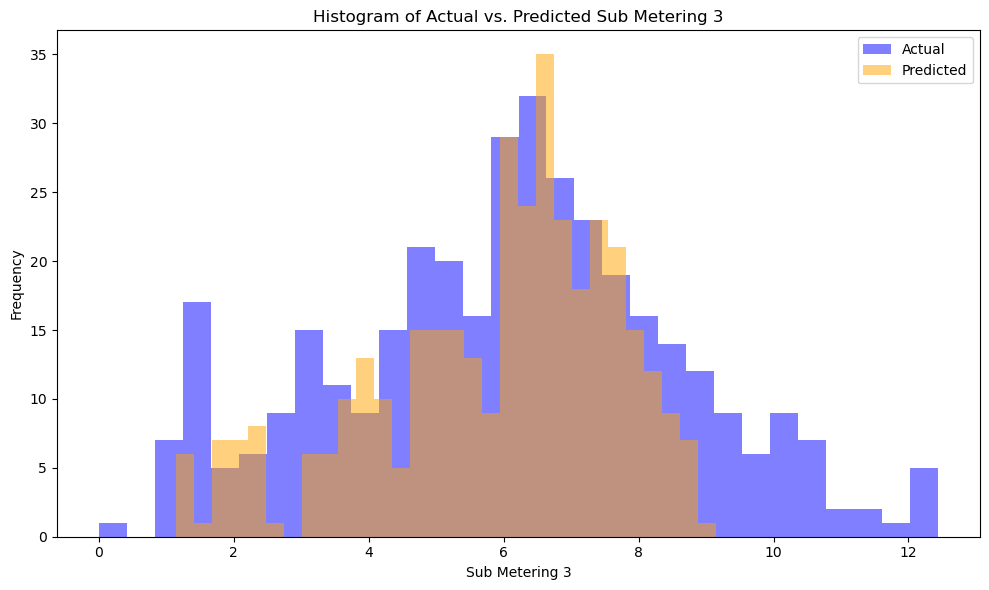

In [28]:
#Histograms of Actual and Predicted Global Active Power
plt.figure(figsize=(10, 6))

plt.hist(y_test_metering, bins=30, alpha=0.5, color='blue', label='Actual')

plt.hist(y_pred_metering, bins=30, alpha=0.5, color='orange', label='Predicted')

plt.title('Histogram of Actual vs. Predicted Sub Metering 3')
plt.xlabel('Sub Metering 3')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

This is the histogram between the actual and predicted values for the daily average of the sub metering 3 and the frequency is higher between when the sub metering 3 is between 5 - 7. The prediction does follow the frequency of the sub metering 3 however when this was around 5 - 7 range there were more actual frequencies than prediction frequency, but for both prediction and actual it shows that range as the highest amount of frequency because we are testing half and training half of the entire data.

## Takeaways

The research question was: How the power consumption in households is used throughout the year along with what factors are contributed to that and how can we make sure this data is useful for energy companies?

To understand the energy consumption throughout December 2006 - December 2008 as the household power consumption data contained we need to find the correlation matrix for the variables of the household power consumption data. Since we are researching about energy global active power variable was the most important variable, and it is shown that it had a perfect strong correlation with global intensity and strong correlation sub metering 3. It also shows that global intensity also had a strong correlation with sub metering 3. So based on this we need to analysis these three important variables 

For prediction I used random forest regression because it has less time complexity and it trained and tested well based on the prediction errors.

So the first analysis was global active power using random forest regression it does a great job in predicting global active power testing 50%. Also the grid search with a tuned hyperparater shows that for the two most feature importance global intensity and sub metering 3 are the most important variables for global active power which also explains the strong correlation. The graph that was scatter with actual and prediction does shows that the global active power was consumed the most during winter. 

For the global intesity analysis which has a perfect positive correlation with global active power. Using the random forest regression it also did a great job in predicting the values with low errors. Using the same tuned hyperparameter it shows that the two most feature importance variables were global active power and sub metering 3. And the graph shows the global intensity is consumed the most during the winter and the least during the summer.

The final analysis was sub metering 3 which is the active energy watt-hour averaged daily which is the energy electric water-heater and air conditioner in the household. And it does shows with the correlation of global active power and global intensity, more energy is consumed in the winter since heater consumes more energy for the air conditioner than cooler. It does a great job in predicting using random forest regression and with the same hyperpatermeter used for global active power and global intensity analysis it shows the strong correlation that correlaation metrixs showed.

For all three analysis the seasonal decomposition shows the consumption is seasonal based on a 30 day period in the two years. 

Using this anlysis the energy companies can use prediction and the correlation of the global intensity and sub metering 3 the see how throughout the season the global active power is consumed, and take measures from this data that would be useful to find ways to make the usage of energy more sustainable and make energy cost effective for the household based on the seasons. To encourage energy sustanablity make the energy costs high in the summer and low during the winter, since it would be more helpful and effective both for the energy companies and household. 

